In [20]:
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import normaltest
import numpy as np

In [21]:
plt.rcParams['font.family'] = 'Heiti TC' 

In [22]:
# 設置 Matplotlib 使用 Heiti TC 字體顯示中文
plt.rcParams['font.family'] = 'Heiti TC'

def create_codebook(df, units_dict=None, detailed_labels=None):
    codebook = pd.DataFrame(columns=['Name', 'Type', 'Width', 'Decimals', 'Label', 'Values', 
                                     'Missing', 'MissingRate', 'Align', 'Measure', 'Mean', 
                                     'Min', 'Max', 'StdDev', 'Median', 'Unit', 'ImbalanceWarning', 'OutlierWarning'])
    rows = []
    outlier_columns = []  # 用於儲存有離群值的欄位名稱

    for col in df.columns:
        # 初步判斷數據類型
        data_type = type(df[col].iloc[0])

        # 判斷數據類型並分類為 Scale 或 Nominal
        if pd.api.types.is_numeric_dtype(df[col]):
            measure = 'Scale'
            decimals = 2 if df[col].dtype == 'float64' else 0
            column_width = df[col].astype(str).str.len().max()  # 字符串表示的最大長度
        elif isinstance(df[col].iloc[0], (str, list)):
            measure = 'Nominal'
            decimals = 0
            column_width = df[col].astype(str).str.len().max()
        elif isinstance(df[col].iloc[0], torch.Tensor):  # 這裡只保留 torch.Tensor
            measure = 'Scale'
            decimals = 2
            column_width = len(str(df[col].iloc[0]))
        else:
            measure = 'Nominal'
            decimals = 0
            column_width = len(str(df[col].iloc[0]))

        # 計算缺失值
        missing_values = df[col].isnull().sum()
        missing_rate = round(missing_values / len(df) * 100, 2)

        # 標籤為變數名稱（可以用 detailed_labels 進行更具描述性的標籤命名）
        label = detailed_labels[col] if detailed_labels and col in detailed_labels else col

        # 如果是分類變數，列出唯一值，並檢查是否存在類別不平衡
        if measure == 'Nominal':
            unique_vals = df[col].unique()
            values = ', '.join([str(val) for val in unique_vals])
            imbalance_warning = "Yes" if df[col].value_counts(normalize=True).max() > 0.8 else "No"
            outlier_warning = 'N/A'  # 對分類變數不檢查離群值
        else:
            values = 'Scale data - None'
            imbalance_warning = 'N/A'
            
            # 計算四分位距來檢測離群值
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # 判斷是否存在離群值
            outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
            outlier_rate = outliers / len(df[col]) * 100
            outlier_warning = "Yes" if outlier_rate > 5 else "No"  # 若離群值超過5%，則觸發警告

            # 如果有離群值，將欄位名稱加入列表
            if outlier_warning == "Yes":
                outlier_columns.append(col)

        # 對齊方式：數字為右對齊，字符串為左對齊
        align = 'Right' if pd.api.types.is_numeric_dtype(df[col]) else 'Left'

        # 計算數值變數的統計摘要
        if measure == 'Scale':
            mean_val = round(df[col].mean(), 2) if pd.api.types.is_numeric_dtype(df[col]) else 'N/A'
            min_val = df[col].min()
            max_val = df[col].max()
            std_dev = round(df[col].std(), 2)
            median_val = df[col].median()
        else:
            mean_val, min_val, max_val, std_dev, median_val = 'N/A', 'N/A', 'N/A', 'N/A', 'N/A'

        # 單位（可根據變數名稱或使用者提供的 units_dict 進行設置）
        unit = units_dict[col] if units_dict and col in units_dict else 'N/A'

        # 添加行到資料字典
        rows.append({
            'Name': col,
            'Type': str(data_type),
            'Width': column_width,
            'Decimals': decimals,
            'Label': label,
            'Values': values,
            'Missing': missing_values,
            'MissingRate': f'{missing_rate}%',
            'Align': align,
            'Measure': measure,
            'Mean': mean_val,
            'Min': min_val,
            'Max': max_val,
            'StdDev': std_dev,
            'Median': median_val,
            'Unit': unit,
            'ImbalanceWarning': imbalance_warning,
            'OutlierWarning': outlier_warning
        })

    # 使用 pd.concat() 創建資料字典 DataFrame
    codebook = pd.concat([pd.DataFrame([row]) for row in rows], ignore_index=True)

    # 繪製有離群值的欄位
    if outlier_columns:
        plot_outlier_columns(df, outlier_columns)

    return codebook

# 定義一個函數來對有離群值的欄位進行 KDE 和假設檢定的視覺化
def plot_outlier_columns(df, outlier_columns):
    # 設定每行的圖表數量，這裡設置為 2 個
    n_cols_per_row = 2
    n_outliers = len(outlier_columns)
    n_rows = (n_outliers + n_cols_per_row - 1) // n_cols_per_row  # 計算需要的行數

    fig, axes = plt.subplots(n_rows, n_cols_per_row, figsize=(18, 3 * n_rows))  # 動態生成子圖
    axes = axes.flatten()  # Flatten 確保每一個 subplot 都可以迭代

    for i, col in enumerate(outlier_columns):
        ax = axes[i]

        # KDE 繪製
        sns.kdeplot(df[col], color='blue', label=f"{col} KDE", fill=True, ax=ax)

        # 計算 IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # 假設檢定 - 常態性檢查
        stat, p_value = normaltest(df[col].dropna())
        
        # 提取統計數據
        mean_val = round(df[col].mean(), 2)
        std_dev = round(df[col].std(), 2)
        min_val = df[col].min()
        max_val = df[col].max()

        # 標註 p-value 和統計摘要
        ax.set_title(f'KDE Plot of {col} with Outliers\n'
                     f'Name: {col}, Mean: {mean_val}, StdDev: {std_dev}, Min: {min_val}, Max: {max_val}\n'
                     f'Normality Test p-value: {p_value:.4f}')
        ax.axvline(x=lower_bound, color='green', linestyle='--', label='Lower Bound (1.5 * IQR)')
        ax.axvline(x=upper_bound, color='red', linestyle='--', label='Upper Bound (1.5 * IQR)')
        
        # 顯示離群值
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        ax.scatter(outliers[col], np.zeros(len(outliers)), color='red', label='Outliers', zorder=5)

        # 設置圖例
        ax.legend()

    # 隱藏空白子圖（如果有）
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # 調整圖表佈局
    plt.tight_layout()
    plt.show()


In [23]:
path = '/Volumes/Debbie 1T/BDSE35-1_Final Project_2/data/實價登錄房價_2012年後_去除outliers_unitPrice_5%_屋齡區間.csv'
df = pd.read_csv(path, encoding="utf-8-sig")

/var/folders/ch/csqy_zv907j03ldtp72n07y80000gn/T/ipykernel_88846/2974476919.py:2: DtypeWarning: Columns (31,34,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, encoding="utf-8-sig")


In [24]:
df.columns

Index(['鄉鎮市區', '交易標的', '土地位置建物門牌', '土地移轉總面積平方公尺', '都市土地使用分區', '非都市土地使用分區',
       '非都市土地使用編定', '交易年月日', '交易筆棟數', '移轉層次', '總樓層數', '建物型態', '主要用途', '主要建材',
       '建築完成年月', '建物移轉總面積平方公尺', '建物現況格局-房', '建物現況格局-廳', '建物現況格局-衛',
       '建物現況格局-隔間', '有無管理組織', '總價元', '單價元平方公尺', '車位類別', '車位移轉總面積(平方公尺)',
       '車位總價元', '備註', '編號', '主建物面積', '附屬建物面積', '陽台面積', '電梯', '移轉編號',
       '車位移轉總面積平方公尺', '建案名稱', '棟及號', '解約情形', '緯度', '經度', 'bad_count',
       'good_count', '建築型態清整', '陽台有無', '是否含額外土地', '建築型態_住商大樓', '建築型態_公寓',
       '建築型態_其他', '建築型態_透天厝', '房地總價元', '格局比例_房', '格局比例_廳', '格局比例_衛', '格局比例_隔間',
       '是否包含車位', '建材_磚石', '建材_鋼筋', '建材_鋼骨', '建材_竹木', '住', '商', '工', '農',
       '移轉層次_數字', '包含騎樓_編碼', '包含屋頂_編碼', '包含一二樓_編碼', '交易年份', '建物移轉總面積坪',
       '單價元每坪', '房地總價元(坪)', '建築完成年', '交易年_民國', '屋齡', '屋齡區間'],
      dtype='object')

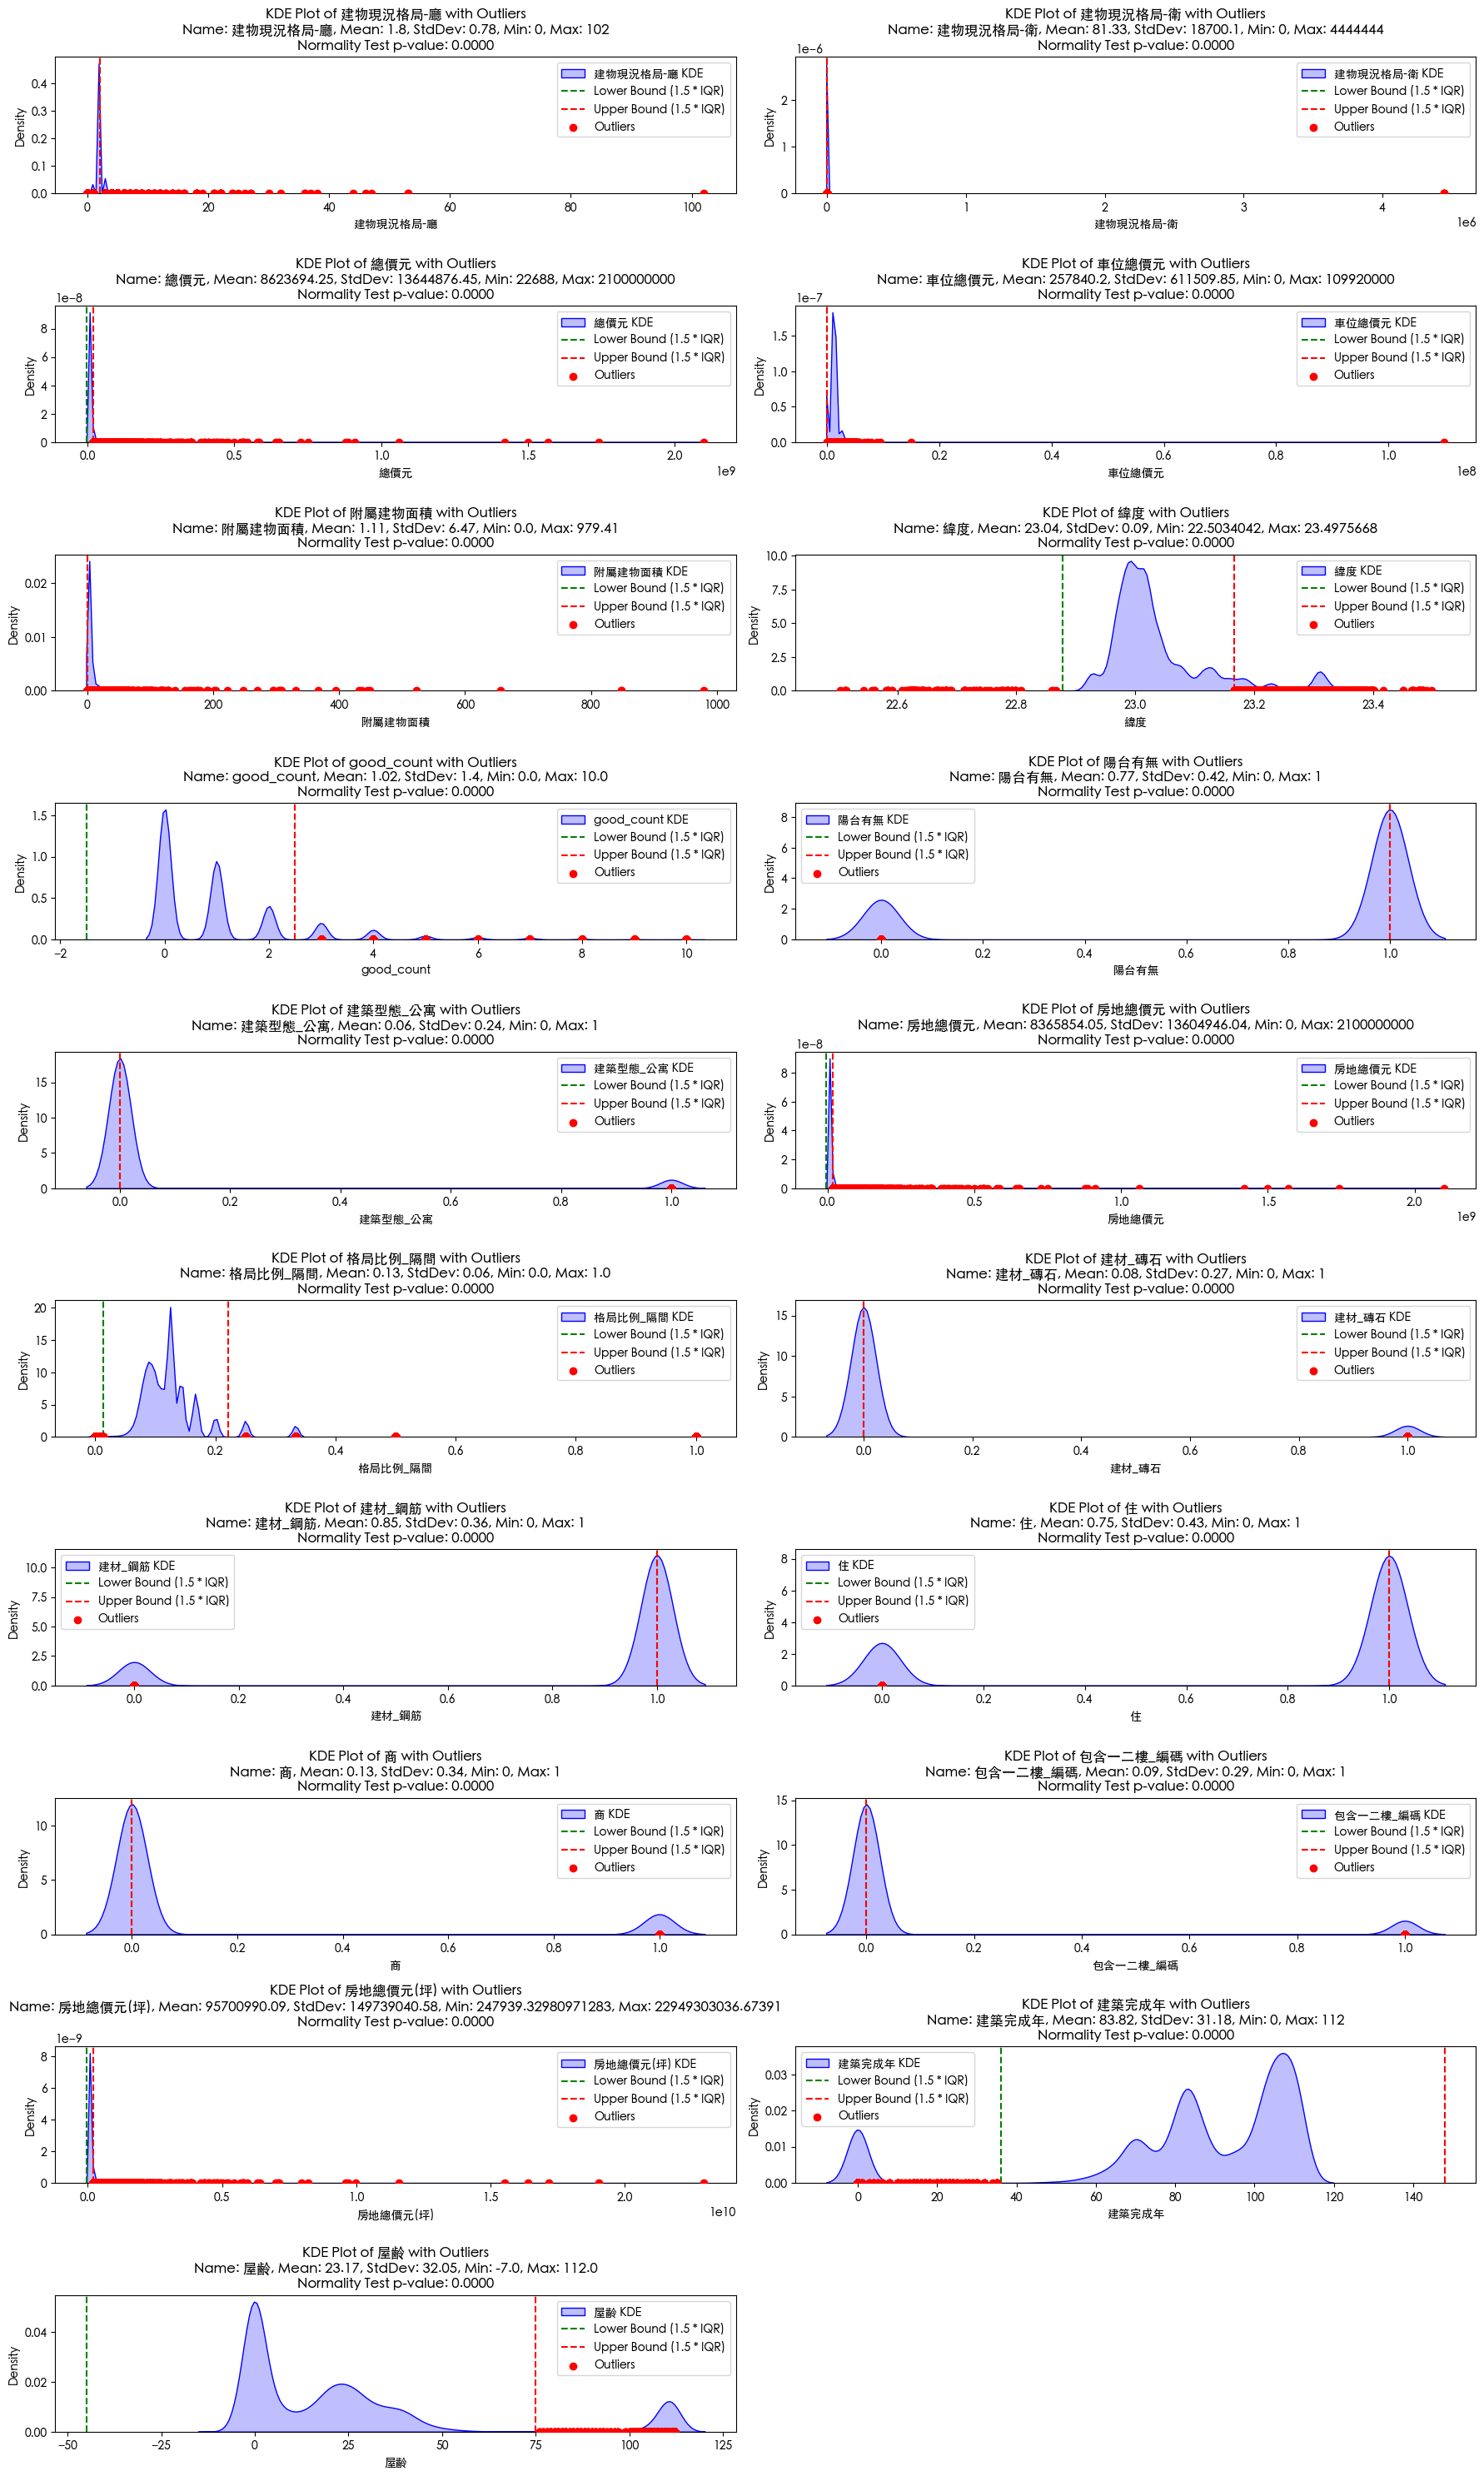

In [25]:
# 假設 create_codebook 函數已定義
codebook_df = create_codebook(df)

# 將資料字典輸出為 CSV 檔案
codebook_df.to_csv('codebook_output.csv', index=False, encoding='utf-8-sig')
